In [1]:
from plurals.agent import Agent
from plurals.deliberation import Chain, Debate, Ensemble
import matplotlib.pyplot as plt
import numpy as np
import random
import seaborn as sns
import pandas as pd
import sys 
from tqdm import tqdm
import os
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
from helpers import *
import lexical_diversity

import numpy as np
from sklearn.metrics import pairwise_distances
from sentence_transformers import SentenceTransformer

# semantic distnace model 
# MODEL = SentenceTransformer('all-mpnet-base-v2')

/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/jashkina/Documents/LocResearch/plurals_system_paper/plurals_system_paper/venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Read in political issues

In [37]:

# Parameters
###################
model = "gpt-4o"
n_words = 100
n_issues = 4
n_per_block = 30
fn = f"../data/raw/{n_words}words_{n_issues}issues_{n_per_block}iters_{model}_pol_responses.csv"
###################

# Read in issues
###################
pol_issues = pd.read_csv("../data/raw/2024-08-08_isidewith_political_issues_popular.csv")
issues = pol_issues.sort_values(by=['initial_order'], ascending=True).head(n_issues)
issues['description_instructions'] = issues['question'] + " " + "Answer in {} words with a rationale.".format(n_words)
issues.to_csv("../data/processed/issue_prompts.csv")
issues_json = issues[['issue', 'description_instructions']].to_json(orient='records')
###################



# Generate responses
###################
data = []
agent_types = {
        'persona_conservative': {"ideology": "conservative"},
        'persona_liberal': {"ideology": "liberal"}, 
        'default_conservative': {"ideology": "conservative"},
        'default_liberal': {"ideology": "liberal"},
}

total_iters = n_issues * n_per_block * len(agent_types)
used_personas = set()
with tqdm(total=total_iters) as pbar:
    counter = 0
    for idx, row in issues.iterrows():
        topic = row['issue']
        prompt = row['description_instructions']
        for iter in range(n_per_block):
            for agent_type in list(agent_types.keys()):
                ideology_query = agent_types[agent_type]['ideology']
                if "persona_" in agent_type:
                    fresh_persona = False
                    while not fresh_persona:
                        agent = Agent(ideology=ideology_query, model=model, kwargs={'seed':counter})
                        if agent.persona not in used_personas:
                            fresh_persona = True             
                            used_personas.add(agent.persona)       
                else:
                    agent = Agent(system_instructions="You are a {}".format(ideology_query), model=model, kwargs={'seed':counter})
                resp = agent.process(prompt)
                data_pt = {
                    "topic": topic,
                    "agent_type": "persona" if "persona_" in agent_type else "default",
                    "ideology": ideology_query,
                    "prompt": prompt,
                    "response": resp, 
                    "iter": iter, 
                    "system_instructions": agent.system_instructions,
                }
                data.append(data_pt)
                counter += 1
                pbar.update(1)

resp_df = pd.DataFrame(data)
resp_df.to_csv(fn)
###################

  1%|          | 4/480 [00:05<10:42,  1.35s/it]

In [2]:
resp_df = pd.DataFrame(data)
resp_df.to_csv("resp_df.csv")

NameError: name 'data' is not defined

In [2]:
resp_df = pd.read_csv("resp_df.csv")

In [ ]:
!pip install lexical-diversity

In [3]:
from lexical_diversity import lex_div as ld
div_data = []


def flatten(xss):
    # https://stackoverflow.com/questions/952914/how-do-i-make-a-flat-list-out-of-a-list-of-lists
    return [x for xs in xss for x in xs]

def compute_diversity_metrics(responses, toks, model):
    pw_dist, centroid_dist, max_pw_distance = sbert_diversity(responses, model)
    d =  {
        'lexical_diversity': ld.ttr(toks),
        'pw_dist': pw_dist,
        'mean_centroid_dist': centroid_dist,
        'max_pw_distance': max_pw_distance,
    }
    return d


def sbert_diversity(responses, model):
    embeds = model.encode(responses)
    centroid = np.mean(embeds, axis=0)
    mean_centroid_distance = np.mean(pairwise_distances(embeds, centroid.reshape(1, -1), metric='cosine'))
    pw_distance = pairwise_distances(embeds, metric='cosine')
    mean_pw_distance = np.mean(pw_distance)
    max_pw_distance = np.max(pw_distance)
    return mean_pw_distance, mean_centroid_distance, max_pw_distance

resp_df['ideology'] = resp_df['ideology']
resp_df['toks'] = resp_df['response'].apply(lambda x: x.split())
resp_df['diversity'] = resp_df['toks'].apply(lambda x: ld.ttr(x))
topics = resp_df['topic'].unique()
ideology = resp_df['ideology'].unique()
agent_type = resp_df['agent_type'].unique()

for topic in topics:
    for agent in agent_type:
        for ideo in ideology:
            responses = resp_df[(resp_df['topic'] == topic) & (resp_df['agent_type'] == agent) & (resp_df['ideology'] == ideo)]['response'].to_list()
            toks = resp_df[(resp_df['topic'] == topic) & (resp_df['agent_type'] == agent) & (resp_df['ideology'] == ideo)]['toks'].to_list()
            toks = flatten(toks)




            data_pt = {
                'topic': topic,
                'agent_type': agent,
                'ideology': ideo,
            }
            data_pt.update(compute_diversity_metrics(responses, toks, MODEL))
            div_data.append(data_pt)

div_df = pd.DataFrame(div_data)



NameError: name 'MODEL' is not defined

In [4]:
import numpy as np
import pandas as pd
from sklearn.metrics import pairwise_distances
from lexical_diversity import lex_div as ld
from scipy.stats import bootstrap

div_data = []

def flatten(xss):
    return [x for xs in xss for x in xs]

def compute_diversity_metrics(responses, toks):
    lexical_diversity = ld.ttr(toks)
    mltd = ld.mtld(toks)
    return {
        'type_token_ratio': lexical_diversity,
        'mltd': mltd,
    }

# Sample data setup and iteration over DataFrame
resp_df['toks'] = resp_df['response'].apply(lambda x: x.split())
topics = resp_df['topic'].unique()
ideology = resp_df['ideology'].unique()
agent_type = resp_df['agent_type'].unique()

for topic in topics:
    for agent in agent_type:
        for ideo in ideology:
            subset = resp_df[(resp_df['topic'] == topic) & (resp_df['agent_type'] == agent) & (resp_df['ideology'] == ideo)]
            responses = subset['response'].tolist()
            toks = flatten(subset['toks'].tolist())
            metrics = compute_diversity_metrics(responses, toks)
            div_data.append({
                'topic': topic,
                'agent_type': agent,
                'ideology': ideo,
                **metrics
            })

div_df = pd.DataFrame(div_data)


In [32]:
import numpy as np
import pandas as pd
from sklearn.utils import resample
from lexical_diversity import lex_div as ld
import nltk 
from nltk.util import ngrams
import numpy as np
from sklearn.utils import resample
import joblib
from tqdm.auto import tqdm
import os

# Statistics functions
############################
def bootstrap_confidence_interval(data, metric_func, n=5000, alpha=0.05, n_jobs=os.cpu_count()-1):
    """
    Bootstrap the confidence interval for a given metric.

    Params:
    - data: The data to compute the metric on.
    - metric_func: The function to compute the metric.
    - n: The number of bootstrap samples to take.
    - alpha: The confidence level.
    - n_jobs: The number of parallel jobs to run. If 1, will run in serial.

    Returns:
    - A dictionary containing the mean, lower, and upper bounds of the confidence interval.

    Notes:
    - Each bootstrap sample uses the random state of the iteration number.
    """

    if n_jobs == 1:
        estimates = [metric_func(resample(data, random_state=_)) for _ in tqdm(range(n), desc='Bootstrapping...')]
    else:
        with joblib.Parallel(n_jobs=n_jobs) as parallel:
            estimates = parallel(joblib.delayed(metric_func)(resample(data, random_state=_)) for _ in tqdm(range(n), desc='Bootstrapping...'))
    
    lower = np.percentile(estimates, 100 * alpha / 2)
    upper = np.percentile(estimates, 100 * (1 - alpha / 2))
    mean = np.mean(estimates)
    return {'mean':mean, 'lower':lower, 'upper':upper}

def compute_diversity_metrics(one_gram, two_gram):
    ttr_onegram = bootstrap_confidence_interval(one_gram, type_token_ratio)
    ttr_twogram = bootstrap_confidence_interval(two_gram, type_token_ratio)
    ttr_threegram = bootstrap_confidence_interval(three_gram, type_token_ratio)
    return [
        {'metric': 'TTR-1', 'mean': ttr_onegram['mean'], 'lower': ttr_onegram['lower'], 'upper': ttr_onegram['upper']},
        {'metric': 'TTR-2', 'mean': ttr_twogram['mean'], 'lower': ttr_twogram['lower'], 'upper': ttr_twogram['upper']},
        {'metric': 'TTR-3', 'mean': ttr_threegram['mean'], 'lower': ttr_threegram['lower'], 'upper': ttr_threegram['upper']},

    ]
############################


# Computing measures 
############################
def type_token_ratio(units):
    """
    Returns the type-token ratio for a list of units, which is
    the number of unique units divided by the total number of units.
    """
    return len(set(units)) / len(units)

def generate_ngrams(text, ngram_lengths):
    """Generates ngrams for a given text and ngram lengths using nltk word_tokenize
    Args:
        text (str): The text to generate ngrams for
        ngram_lengths (list): A list of integers specifying the ngram lengths to generate
        
    Returns:
        list: A list of ngrams for the given text and ngram lengths
    """
    words = nltk.word_tokenize(text)
    
    ngram_list = []
    for n in ngram_lengths:
        ngram_list.extend([' '.join(ngram) for ngram in ngrams(words, n)])
    
    return ngram_list
############################



resp_df['one_gram'] = resp_df['response'].apply(lambda x: generate_ngrams(x, [1]))
resp_df['two_gram'] = resp_df['response'].apply(lambda x: generate_ngrams(x, [2]))
resp_df['three_gram'] = resp_df['response'].apply(lambda x: generate_ngrams(x, [3]))

grouped = resp_df.groupby(['topic', 'agent_type', 'ideology'])
results = []
# Iterate over each group
for (topic, agent, ideo), group in grouped:
    one_gram = [token for sublist in group['one_gram'] for token in sublist]  
    two_gram = [token for sublist in group['two_gram'] for token in sublist]  
    three_gram = [token for sublist in group['three_gram'] for token in sublist]

    metrics = compute_diversity_metrics(one_gram, two_gram)
    for metric in metrics:
        metric.update({
            'topic': topic,
            'agent_type': agent,
            'ideology': ideo
        })
        results.append(metric)

# Create DataFrame from the collected data
final_df = pd.DataFrame(results)

Bootstrapping...: 100%|██████████| 5000/5000 [00:01<00:00, 2906.67it/s]


In [20]:
import nltk
from nltk import ngrams

def generate_ngrams(text, ngram_lengths):
    """Generates ngrams for a given text and ngram lengths using nltk word_tokenize
    Args:
        text (str): The text to generate ngrams for
        ngram_lengths (list): A list of integers specifying the ngram lengths to generate
        
    Returns:
        list: A list of ngrams for the given text and ngram lengths
    """
    words = nltk.word_tokenize(text)
    
    ngram_list = []
    for n in ngram_lengths:
        ngram_list.extend([' '.join(ngram) for ngram in ngrams(words, n)])
    
    return ngram_list



['This',
 'is',
 'a',
 'test',
 'sentence',
 'This is',
 'is a',
 'a test',
 'test sentence',
 'This is a',
 'is a test',
 'a test sentence']

/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_84966/1486714943.py:13: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  ax = sns.catplot(data=final_df,
/var/folders/gc/36c2knv139jfg23x561mj5xr0000gp/T/ipykernel_84966/1486714943.py:13: UserWarning: 

The `join` parameter is deprecated and will be removed in v0.15.0. You can remove the line between points with `linestyle='none'`.

  ax = sns.catplot(data=final_df,


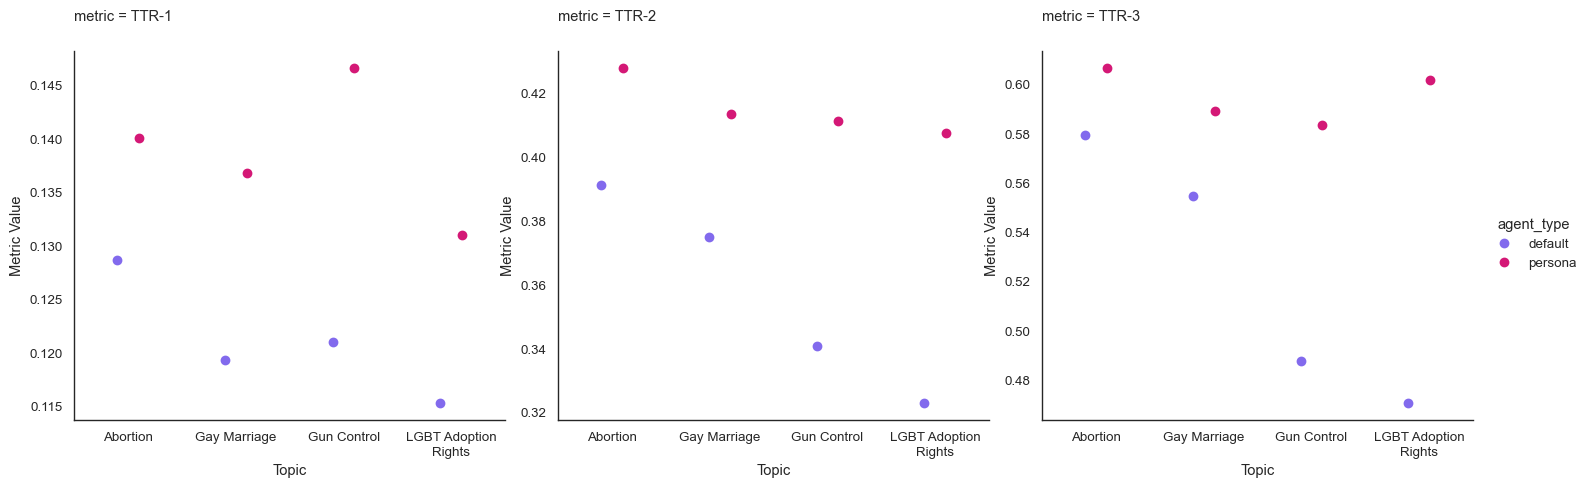

In [48]:
import matplotlib.pyplot as plt

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


make_aesthetic(font_scale=1.1)


final_df['topic2'] = final_df['topic'].apply(lambda x: "LGBT Adoption\nRights" if x == "LGBT Adoption Rights" else x)
# Create the point plot
ax = sns.catplot(data=final_df, 
                   y='mean', 
                   x='topic2',
                   kind='point',
                   join=False,
                   hue='agent_type', 
                   col='metric',
                   sharey=False,
                   dodge=0.2,
                   ci=None)


for ax in ax.axes.flat:
    ax.set_xlabel('Topic')
    ax.set_ylabel('Metric Value')


